In [1]:
%load_ext autoreload
%config Completer.use_jedi = False

In [2]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt


# Topology optimization for the fundamental frequency of a vibrating structure

## 1. Example problem definition

In [74]:
mesh = FEMOL.mesh.rectangle_Q4(75, 25, 75, 25)

problem = FEMOL.FEM_Problem(mesh=mesh, physics='modal', model='plane')
material1 = FEMOL.materials.isotropic_bending_benchmark()
problem.define_materials(material1)
problem.define_tensors(1)  # thick=1

problem.add_fixed_domain(FEMOL.domains.inside_box([0], [[0, 15]]), ddls=[0, 1])

#problem.add_forces(force=[0, 0, -1, 0, 0, 0], domain=FEMOL.domains.inside_box([[9,11]], [[9,11]]))

w, v = problem.solve(filtre=0)


solving using scipy
solved in :  30.60699987411499  s


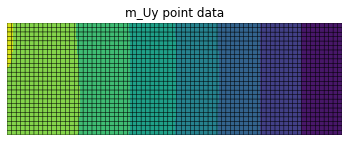

In [75]:
mesh.add_mode('m', v[0], 2)
mesh.plot.point_data('m_Uy')
reference_vector = v[0]  # Save for MAC Analysis

## 2. The optimization problem formulation

### Optimization problem constraints

maximize : $\; min\; (\omega_j^2) \;\; j = 1,...,J $

with : $\; \rho_1, ..., \rho_{N_E}$ The individual element densities of the problem

and : $j = 1,...,J$ The vibration modes of the structure

Subject to :

The eigenvalue theorem : 

$ K \phi_j = \omega_j^2 M \phi_j \; \; j = 1, ..., J$

The orthogonality criteria :

$ \phi_j^T M \phi_k = \delta_{jk}, \; \; j \geq k, \;\; kj = 1,...,J$

Where : $\delta_{jk} = 1$ if $i=k$ and $0$ if $j \neq k$

The Volume constraint :

$\sum_{e=1}^{N_e} \; \rho_e V_e - V^* \leq 0$ and $V^* = \alpha V_0$

Where : $\alpha$ is the volume fraction constraint and $V_0$ is the domain volume

And the admissible density values :

$0 < \rho_{min} \leq \rho_e \leq 1$ for $e = 1, ..., N_e$

Here, $\rho_{min}$ represents the admissible lower bound to the element density (typically $10^{-3}$)

### Sensitivity Analysis

The sensibility of the eigenvalue is given by $\frac{\partial \lambda_j}{\partial \rho_e}$ where $\lambda_j = \omega_j^2$ is obtained by differentiating the eigenvalue theorem with respect to $\rho_e$ :



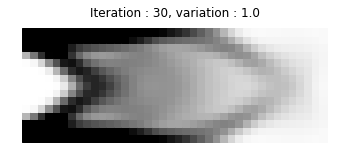

In [73]:
SIMP = FEMOL.SIMP_VIBE(problem, objective='max eig')
mesh = SIMP.solve(reference_vector)
